### Dans ce notebook nous essaierons de reconstruire entièrement l'architecture proposé dans : 

`Liang E., Díaz R. F., Davis A. B., Dumusque X. (2024). AESTRA: Deep Learning for Precise Radial Velocity Estimation in the Presence of Stellar Activity, Astronomy & Astrophysics.`

https://iopscience.iop.org/article/10.3847/1538-3881/ad0e01/pdf

![image](full_architecture.png)

- Plot toutes les étapes intermédiaires (yobs, bobs, robs , etc...)
- D'abord injecter le signal planétaire puis entrainer le modele dessus et tracer périodogramme
- Augmenter 5000 -> 5050 => 5000 - 5100 puis entrainer, injecter le meme signal et comparer les deux pics du periodo 
- Comparer les valeurs absolues que sort le RV estimator, et voir si le v0 est négligeable ou non ?
- Bruit inutile pour l'instant le mettre de côté

In [57]:
from util import torch_interp, SpectrumDataset, cubic_transform
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from time import time
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, Dataset
from torch.utils.data import DataLoader
import pickle
from scipy.interpolate import interp1d
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"On tourne sur {'GPU' if device.type == 'cuda' else 'CPU'}")
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from astropy.timeseries import LombScargle

c = 299792458.
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

On tourne sur GPU


### Commençons par l'architecture de SPENDER, l'autoencodeur utilisé dans AESTRA venant de ce papier : 

![image](spender_architecture.png)

In [2]:
class MLP(nn.Module):
    """
        Réseau Multi-Perceptron classique
    """
    def __init__(
        self, 
        n_in, 
        n_out, 
        n_hidden=(16, 16, 16),
        act=(nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()),
        dropout=0
    ):
        super(MLP, self).__init__()
        
        n_ = [n_in, *n_hidden, n_out]
        
        layers = []
        
        for i in range(0, len(n_)-1):
            layers.append(nn.Linear(in_features=n_[i], out_features=n_[i+1]))
            layers.append(act[i])
            layers.append(nn.Dropout(p=dropout))
            
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)
    
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        conv_ksize,
        conv_stride,
        conv_padding,
        maxpool_ksize,
        maxpool_stride,
        maxpool_padding,
        maxpool_ceil_mode,
        act=nn.LeakyReLU(),
        dropout=0,
        
    ):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv1d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=conv_ksize, 
            stride=conv_stride, 
            padding=conv_padding
        )
        
        self.instancenorm = nn.InstanceNorm1d(num_features=out_channels)
        
        self.activation = act
        self.dropout = nn.Dropout(p=dropout)
        
        # Si on veut rajouter une couche maxpool (pas le cas du dernier convblock de spender)
        if (maxpool_ksize is not None) and (maxpool_padding is not None) and (maxpool_stride is not None) and (maxpool_ceil_mode is not None):
            self.maxpool = nn.MaxPool1d(
                kernel_size=maxpool_ksize, 
                stride=maxpool_stride, 
                padding=maxpool_padding,
                ceil_mode=maxpool_ceil_mode
            )
        else:
            self.maxpool = None
        
    def forward(self, x):
        x = self.conv(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        
        if self.maxpool is not None:
            x = self.maxpool(x)
        
        return x
    
class SPENDER(nn.Module):
    """
    
        * self.n_pixel_in              -> Nb de pixel du spectre en entrée           dtype=int
        
        * self.wave_block          -> tensor de taille [B, n_pixel_in]           dtype=float32
        
    """
    def __init__(self, n_pixel_in):
        super(SPENDER, self).__init__()
        
        # ---------- Encoder ----------
        
        # ConvBlock n°1
        self.convblock1 = ConvBlock(
            in_channels=1,
            out_channels=128,
            
            conv_ksize=5,
            conv_stride=1,
            conv_padding=2,
            
            maxpool_ksize=5,
            maxpool_stride=5,
            maxpool_padding=0,
            maxpool_ceil_mode=True,
            
            act=nn.PReLU(num_parameters=128),
            dropout=0
        )
        
        # ConvBlock n°2
        self.convblock2 = ConvBlock(
            in_channels=128,
            out_channels=256,
            
            conv_ksize=11,
            conv_stride=1,
            conv_padding=5,
            
            maxpool_ksize=11,
            maxpool_stride=11,
            maxpool_padding=0,
            maxpool_ceil_mode=True,
            
            act=nn.PReLU(num_parameters=256),
            dropout=0
        )
        
        # ConvBlock n°3
        self.convblock3 = ConvBlock(
            in_channels=256,
            out_channels=512,
            
            conv_ksize=21,
            conv_stride=1,
            conv_padding=10,
            
            maxpool_ksize=None,
            maxpool_stride=None,
            maxpool_padding=None,
            maxpool_ceil_mode=None,
            
            act=nn.PReLU(num_parameters=512),
            dropout=0
        )
        
        # Softmax du bloc d'attention
        self.softmax = nn.Softmax(dim=-1)
        
        # MLP pour convertir la sortie de l'attention block en vecteur de l'espace latent
        self.latentMLP = MLP(
            n_in=256,
            n_out=3,
            n_hidden=(128, 64, 32),
            act=(nn.PReLU(128), nn.PReLU(64), nn.PReLU(32), nn.PReLU(3)),
            dropout=0
        )
        
        # ---------- Decoder ----------
        self.decoder = MLP(
            n_in=3,
            n_out=n_pixel_in,
            n_hidden=(64, 256, 1024),
            act=(nn.PReLU(64), nn.PReLU(256), nn.PReLU(1024), nn.PReLU(n_pixel_in)),
            dropout=0
        )
        
        self.LSF = nn.Conv1d(1, 1, 5, bias=False, padding='same')

        self.current_latent = None

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Encoding
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        C = x.shape[1] // 2 # Nombre de canaux
        h, k = torch.split(x, [C, C], dim=1) # On divise en deux
        a = self.softmax(k)
        e = torch.sum(h * a, dim=-1) # On somme selon les longueurs d'ondes -> sortie [B, C]
        s = self.latentMLP(e) # Vecteur latent

        self.current_latent = s
        
        # Decoding
        x = self.decoder(s)

        x = x.unsqueeze(1)
                
        # Convolve
        x = self.LSF(x)

        x = x.squeeze(1)

        return x

### Ensuite attaquons nous à la partie RV Estimator

![image](rvestimator_architecture.png)

In [3]:
class RVEstimator(nn.Module):
    """Some Information about RVEstimator"""
    def __init__(
        self,
        n_pixel_in,
        dropout=0
                 ):
        super(RVEstimator, self).__init__()
                
        # ConvBlock n°1
        self.convblock1 = ConvBlock(
            in_channels=1,
            out_channels=128,
            
            conv_ksize=5,
            conv_stride=1,
            conv_padding=2,
            
            maxpool_ksize=5,
            maxpool_stride=5,
            maxpool_padding=0,
            maxpool_ceil_mode=False,
            
            act=nn.PReLU(num_parameters=128),
            dropout=0
        )
        
        # ConvBlock n°2
        self.convblock2 = ConvBlock(
            in_channels=128,
            out_channels=64,
            
            conv_ksize=10,
            conv_stride=1,
            conv_padding=5,
            
            maxpool_ksize=10,
            maxpool_stride=10,
            maxpool_padding=0,
            maxpool_ceil_mode=False,
            
            act=nn.PReLU(num_parameters=64),
            dropout=0
        )
        
        self.n_features_out = 64 * (n_pixel_in // 5) // 10
        
        print(self.n_features_out)
        
        self.softmax = nn.Softmax(dim=-1)
        
        self.flatten = nn.Flatten() # Entrée de la taille [B, C, L] avec B = taille du batch, C = nb de canaux et L = segments wavelength
        self.mlp = MLP(
            n_in = self.n_features_out,
            n_out = 1,
            n_hidden=(128, 64, 32),
            act=(nn.PReLU(128), nn.PReLU(64), nn.PReLU(32), nn.Identity()),
            dropout=dropout
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.softmax(x)
        x = self.flatten(x)
        x = self.mlp(x)

        return x

# Entraînement

In [4]:
def get_LRV(
        batch_yobs, 
        b_obs, 
        dataset,
        model,
        sigmav=0.3,
        with_noise=True, 
        interp_method='torch_interp', 
        GPU=True
    ):


    # On récupère la taille de batch de l'itération
    current_B = batch_yobs.shape[0]

    # On créer batch_voffset avec des vitesses uniformèment réparties entre -3 et 3
    batch_voffset = torch.zeros(size=(current_B, )).uniform_(-3, 3)


    if GPU:
        # On déplace sur GPU
        batch_yobs = batch_yobs.to(device)
        batch_voffset = batch_voffset.to(device)


    batch_yaug = dataset.doppler_shift_batch(batch_yobs, batch_voffset, interp_method)

    # Si on veut rajouter du bruit
    if with_noise:
        noise = torch.randn_like(batch_yaug, dtype=batch_yaug.dtype) * 0.001 # std = 0.001 
        ratio = 0.2 # On veut appliquer un bruit uniforme sur 20 % des pixels
        noise_mask = torch.rand_like(batch_yaug, dtype=batch_yaug.dtype) > ratio
        noise[noise_mask] = 0

        batch_yaug += noise


    # On récupère les spectres résiduels
    batch_robs = (batch_yobs - b_obs).float() # Le réseau attend des float32 donc on cast le bon type
    batch_raug = (batch_yaug - b_obs).float()

    # On injecte [B, n_pixel] dans le réseau qui unsqueeze de lui même pour la dim des canaux dans le .forward()
    batch_vobs_pred = model(batch_robs) # -> De la forme [B, 1]
    batch_vaug_pred = model(batch_raug) # -> De la forme [B, 1]

    batch_voffset_pred = (batch_vaug_pred - batch_vobs_pred)
    
    # On rajoute une dimension pour passer de [B] à [B, 1] et faire la soustraction 
    batch_voffset = batch_voffset.unsqueeze(-1)

    loss = (1/sigmav)**2 * torch.nn.functional.mse_loss(batch_voffset_pred, batch_voffset)

    return loss, batch_voffset_pred

def get_Lfid_Lreg(batch_yobs, b_obs, b_rest, dataset, batch_vencode, model, k_reg=0, sigmay=0.1, GPU=True):

    current_B = batch_yobs.shape[0]

    if GPU:
        batch_yobs = batch_yobs.to(device)

    # On récupère les spectres résiduels
    batch_robs = (batch_yobs - b_obs).float() # Le réseau attend des float32 donc on cast le bon type



    batch_yact = model(batch_robs)

    batch_yrest = batch_yact + b_rest

    # Doppler Shift Resample
    wave_block = dataset.wave_torch.unsqueeze(0).expand(current_B, -1)

    batch_zoffset = batch_vencode / dataset.c_tensor

    batch_yrest = batch_yrest.double()
    
    wave_redshifted_block = wave_block - wave_block * batch_zoffset
    
    batch_yobsprime = torch_interp(wave_block, wave_redshifted_block, batch_yrest, dim=-1)
    
    batch_yobsprime = batch_yobsprime.float()

    L_fid = torch.nn.functional.mse_loss(batch_yobsprime, batch_yobs.float())

    L_reg = k_reg * torch.sum((batch_yact**2) / sigmay**2) / (batch_yact.shape[0] * batch_yact.shape[1])

    return L_fid, L_reg


In [5]:
# ----------- Hyperparamètres ----------- 

B = 64
n_epochs = 500
learning_rate = 1e-4

lambda_min = 5000
lambda_max = 5050
n_pixel = 2000 # = n_pixel

# LRV
sigmav = 0.3

# Lreg
sigmay = 0.1
k_reg = 0

# ----------- Dataset -----------

dataset = SpectrumDataset(n_pixel, lambda_min, lambda_max)

train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))

train_set, test_set = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_set, batch_size=B, shuffle=True)
test_dataloader  = DataLoader(test_set,  batch_size=B, shuffle=False)

spec_template = dataset.template_spec_torch
n_pixel = dataset.n_pixel

phase1_with_noise = True # Si on veut rajouter du bruit photonique lors de l'entraînement du RV_Estimator (Phase 1)
phase1_patience = 30 # Nombre d'epoch pour lequel on veut une test loss inférieur à 1 avant de terminer la Phase 1
# ----------- Model -----------

rvestimator = RVEstimator(n_pixel_in=n_pixel, dropout=0.)
rvestimator_optimizer = torch.optim.Adam(
    params=rvestimator.parameters(), 
    lr=learning_rate)

spender = SPENDER(n_pixel_in=n_pixel)

b_rest = nn.Parameter(torch.randn(size=(1, n_pixel)))

aestra_optimizer = torch.optim.Adam(
    params=list(rvestimator.parameters()) + list(spender.parameters()) + [b_rest],
    lr=learning_rate
)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(rvestimator_optimizer, max_lr=0.001, steps_per_epoch=len(train_dataloader), epochs=n_epochs)
interp_method = 'torch_interp'
GPU = True

# On met template_spec_torch sous forme de tenseur [1, n_pixel] pour profiter du broadcasting sans avoir à dupliquer
b_obs = dataset.template_spec_torch.unsqueeze(0)

# ----------- Training -----------

# On déplace en amont pour ne pas répéter inutilement l'opération dans la boucle d'entraînement
if GPU:
    dataset.wave_torch = dataset.wave_torch.to(device)
    dataset.template_spec_torch = dataset.template_spec_torch.to(device)
    rvestimator = rvestimator.to(device)
    spender = spender.to(device)
    dataset.c_tensor = dataset.c_tensor.to(device)
    b_rest = b_rest.to(device)
    b_obs = b_obs.to(device)


train_losses = []
test_losses = []

test_RV_losses = []

# Pour plot le taux d'apprentissage
all_learning_rates = []

# ------- PHASE 1 ------- RV Estimator
print("-------- PHASE 1 -------- RV Estimator")
start_training = time()
for t in range(1, 1000000000):
    print(f"-- Epoch {t} --")

    if len(test_losses) > 10:
        if np.mean(test_losses[-phase1_patience:]) < 1.0: # Si les 10 dernières test losses sont inférieur à 1
            print("---- Phase 1 Terminée ! ----")
            end_training = time()
            print(f"---- Durée de la phase 1 : {(end_training - start_training):.2f} s")
            break

    # -- Training Part --
    train_loss = 0
    rvestimator.train()
    for batch_yobs, indices in train_dataloader:
        
        # Taille du batch courant
        current_B = batch_yobs.shape[0]
        
        # -- Forward -- On récupère la loss RV du batch
        L_RV, batch_vencode = get_LRV(
            batch_yobs, 
            b_obs, 
            dataset,
            rvestimator,
            sigmav=sigmav,
            with_noise=phase1_with_noise, 
            interp_method=interp_method, 
            GPU=GPU,
        )

        # -- Backward -- On ajuste les paramètres du réseau RV
        rvestimator_optimizer.zero_grad()
        L_RV.backward()
        rvestimator_optimizer.step()

        # On veut calculer la loss totale sur l'époque donc on pondère par la taille de batch pour avoir quelque chose de cohérent
        batch_LRV = L_RV * current_B

        train_loss += batch_LRV
    
    train_loss = train_loss / len(train_set)

    train_losses.append(train_loss.detach().cpu())

    print(f"Train Loss : {train_loss}")

    # -- Validation Part --
    test_loss = 0
    rvestimator.eval()
    with torch.no_grad():
        for batch_yobs, indices in test_dataloader:

            # Taille du batch courant
            current_B = batch_yobs.shape[0]
            
            # -- Forward -- On récupère la loss RV du batch
            L_RV, batch_vencode = get_LRV(
                batch_yobs, 
                b_obs, 
                dataset,
                rvestimator,
                sigmav=sigmav,
                with_noise=phase1_with_noise, 
                interp_method=interp_method, 
                GPU=GPU,
            )

            # On veut calculer la loss totale sur l'époque donc on pondère par la taille de batch pour avoir quelque chose de cohérent
            batch_LRV = L_RV * current_B

            test_loss += batch_LRV
        
        test_loss = test_loss / len(test_set)

        test_losses.append(test_loss.detach().cpu())

        print(f"Test Loss : {test_loss}")

        # scheduler.step()


    current_lr = rvestimator_optimizer.param_groups[0]['lr']
    all_learning_rates.append(current_lr)

# ------- PHASE 2 ------- RV Estimator + SPENDER
print("-------- PHASE 2 -------- RV Estimator + SPENDER")
start_training = time()
for t in range(1, n_epochs):
    print(f"-- Epoch {t} --")

    # -- Training Part --
    train_loss = 0
    spender.train()
    rvestimator.train()
    for batch_yobs, indices in train_dataloader:
            
        # Taille du batch courant
        current_B = batch_yobs.shape[0]

        # -- Forward -- On récupère la loss RV du batch
        L_RV, batch_vencode = get_LRV(
            batch_yobs, 
            b_obs, 
            dataset,
            rvestimator,
            sigmav=sigmav,
            with_noise=phase1_with_noise, 
            interp_method=interp_method, 
            GPU=True
        )

        L_fid, L_reg = get_Lfid_Lreg(batch_yobs, b_obs, b_rest, dataset, batch_vencode, model=spender, k_reg=0, sigmay=0.1, GPU=True)

        L_tot = L_RV + L_fid + L_reg
        
        # -- Backward -- On ajuste les paramètres du réseau RV
        aestra_optimizer.zero_grad()
        L_tot.backward()
        aestra_optimizer.step()

        # On veut calculer la loss totale sur l'époque donc on pondère par la taille de batch pour avoir quelque chose de cohérent
        batch_Ltot = L_tot * current_B

        train_loss += batch_Ltot
    
    train_loss = train_loss / len(train_set)

    train_losses.append(train_loss.detach().cpu())

    print(f"Train Loss : {train_loss}")

    # -- Validation Part --
    test_loss = 0
    test_RV_loss = 0
    spender.eval()
    rvestimator.eval()
    with torch.no_grad():
        for batch_yobs, indices in test_dataloader:

            # Taille du batch courant
            current_B = batch_yobs.shape[0]

            # -- Forward -- On récupère la loss RV du batch
            L_RV, batch_vencode = get_LRV(
                batch_yobs, 
                b_obs, 
                dataset,
                rvestimator,
                sigmav=sigmav,
                with_noise=phase1_with_noise, 
                interp_method=interp_method, 
                GPU=True
            )

            L_fid, L_reg = get_Lfid_Lreg(batch_yobs, b_obs, b_rest, dataset, batch_vencode, model=spender, k_reg=0, sigmay=0.1, GPU=True)

            L_tot = L_RV + L_fid + L_reg
            
            # On veut calculer la loss totale sur l'époque donc on pondère par la taille de batch pour avoir quelque chose de cohérent
            batch_Ltot = L_tot * current_B
            batch_LRV = L_RV * current_B
            
            test_loss += batch_Ltot
            test_RV_loss += batch_LRV

        test_loss = test_loss / len(test_set)
        test_RV_loss = test_RV_loss / len(test_set)

        test_losses.append(test_loss.detach().cpu())
        test_RV_losses.append(test_RV_loss.detach().cpu())


        print(f"Test Loss : {test_loss}")

        # scheduler.step()


    current_lr = rvestimator_optimizer.param_groups[0]['lr']
    all_learning_rates.append(current_lr)
end_training = time()

print(f"---- Durée de la phase 2 : {(end_training - start_training):.2f} s")

2560
-------- PHASE 1 -------- RV Estimator
-- Epoch 1 --
Train Loss : 34.879127502441406
Test Loss : 34.44347381591797
-- Epoch 2 --
Train Loss : 32.84334945678711
Test Loss : 32.060001373291016
-- Epoch 3 --
Train Loss : 33.5336799621582
Test Loss : 32.188907623291016
-- Epoch 4 --
Train Loss : 32.25321578979492
Test Loss : 32.61567687988281
-- Epoch 5 --
Train Loss : 33.624855041503906
Test Loss : 31.098527908325195
-- Epoch 6 --
Train Loss : 34.8637809753418
Test Loss : 33.033729553222656
-- Epoch 7 --
Train Loss : 32.0848388671875
Test Loss : 33.84709930419922
-- Epoch 8 --
Train Loss : 32.40788269042969
Test Loss : 33.14152908325195
-- Epoch 9 --
Train Loss : 30.842702865600586
Test Loss : 28.610095977783203
-- Epoch 10 --
Train Loss : 31.764997482299805
Test Loss : 30.162931442260742
-- Epoch 11 --
Train Loss : 30.8874454498291
Test Loss : 30.17249298095703
-- Epoch 12 --
Train Loss : 29.165809631347656
Test Loss : 27.100343704223633
-- Epoch 13 --
Train Loss : 29.42469024658203

In [135]:
%matplotlib qt
plt.figure(figsize=(18, 6))
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axvline(x = 0, color='gray', linestyle='dotted')
plt.axvline(x = 311, color='gray', linestyle='dotted')
plt.axvline(x = 499+311, color='gray', linestyle='dotted')
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.figtext(
    x=0.2,
    y=0.6,
    s=(
        r"Phase 1 : On entraîne uniquement le RV Estimator"
    ),
    backgroundcolor='lightgray',
    fontsize='large'
)
plt.figtext(
    x=0.2,
    y=0.40,
    s=(
        r"$L_{\text{RV}} = \frac{1}{N} \sum_{i=1}^{N} \left(\frac{v_{\text{aug},i} - v_{\text{obs},i} - v_{\text{offset},i}}{\sigma_v} \right)^2$"
    ),
    backgroundcolor='lightyellow',
    fontsize='xx-large'
)

plt.figtext(
    x=0.6,
    y=0.825,
    s=(
        r"Phase 2 : On entraîne tout"
    ),
    backgroundcolor='lightgray',
    fontsize='large'
)
plt.figtext(
    x=0.6,
    y=0.7,
    s=r"$L_{\text{RV}} = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{v_{\text{aug},i} - v_{\text{obs},i} - v_{\text{offset},i}}{\sigma_v} \right)^2$",
    backgroundcolor='lightyellow',
    fontsize='xx-large'
)

plt.figtext(
    x=0.6,
    y=0.5,
    s=r"$L_{\text{reg}} = \frac{k_{\text{reg}}}{N L} \sum_{i=1}^{N} \left\| \frac{\mathbf{y}_{\text{act},i}}{\sigma_y} \right\|^2$",
    backgroundcolor='lightyellow',
    fontsize='xx-large'
)

plt.figtext(
    x=0.6,
    y=0.3,
    s=r"$L_{\text{fid}} = \frac{1}{NL} \sum_{i=1}^{N} \left\| \mathbf{w}_i \odot \left( \mathbf{y}_{i,\text{obs}} - \mathbf{y}'_{i,\text{obs}} \right) \right\|^2$",
    backgroundcolor='lightyellow',
    fontsize='xx-large'
)




# plt.plot(np.arange(311, 311+499, 1),test_RV_losses, label='Test RV')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [6]:
np.sqrt(test_RV_losses[-1]* sigmav**2)

tensor(0.2869)

In [17]:
spender.eval()
rvestimator.eval()

latents_list = []
vencode_list = []

with torch.no_grad():
    for batch_yobs, indices in test_dataloader:
        
        # Récupération des vitesses encodées
        _, batch_vencode = get_LRV(
            batch_yobs, 
            b_obs, 
            dataset,
            rvestimator,
            sigmav=sigmav,
            with_noise=False,  # pas de bruit pour analyse propre
            interp_method=interp_method, 
            GPU=GPU
        )
        vencode_list.append(batch_vencode.cpu())

        # Reconstruction pour obtenir le latent actuel dans SPENDER
        _ = spender(batch_yobs.float().to(device))  # remplit self.current_latent
        latents_list.append(spender.current_latent.cpu())

# Concaténation finale
latents_all = torch.cat(latents_list, dim=0)     # shape (N_test, latent_dim)
vencode_all = torch.cat(vencode_list, dim=0)     # shape (N_test,)


In [130]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert tensors to numpy arrays
lat = latents_all.cpu().numpy()
v = vencode_all.cpu().numpy()

%matplotlib qt
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(lat[:, 0], lat[:, 1], lat[:, 2], c=v, s=10)
cb = fig.colorbar(sc, ax=ax)
cb.set_label('v_encode (m/s)')
ax.set_xlabel('Latent dim 1')
ax.set_ylabel('Latent dim 2')
ax.set_zlabel('Latent dim 3')
plt.title('3D scatter of latent vectors color-coded by v_encode')
plt.tight_layout()
plt.show()


### Noyeau de la LSF appris

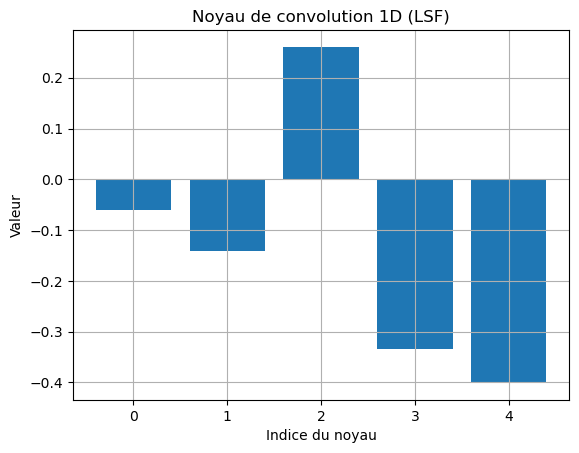

In [129]:
noyau = spender.LSF.weight.detach().cpu().view(-1)  # Tensor 1D, sans gradients

indices = range(len(noyau))

%matplotlib inline
plt.bar(indices, noyau.numpy())
plt.title("Noyau de convolution 1D (LSF)")
plt.xlabel("Indice du noyau")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()


Voir entrainement sans LSF

RMSE = 9.0630 m/s
Biais moyen = -0.6272 m/s


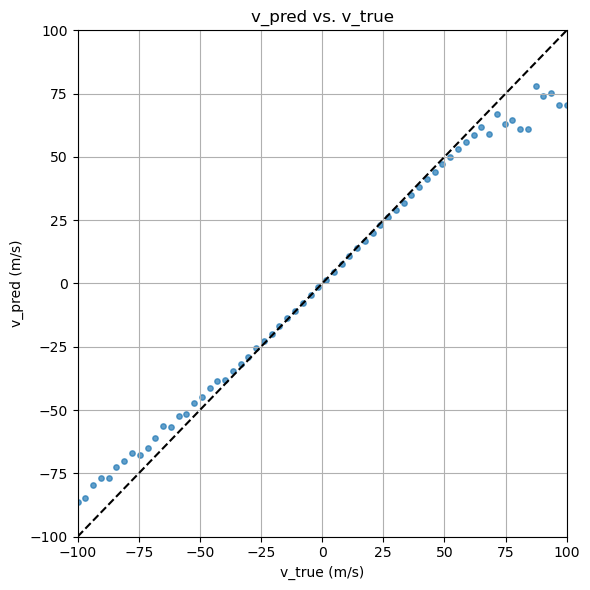

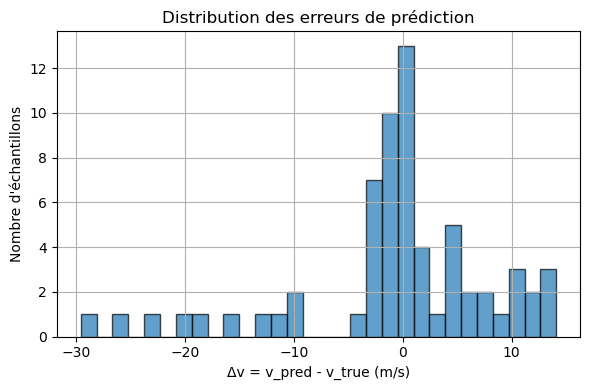

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1) Récupération d'un batch de spectres tests
batch_yobs, _ = next(iter(test_dataloader))         # shape [B, n_pixel]
batch_yobs = batch_yobs.to(device)

# 2) Génération de vitesses "vraies"
B = batch_yobs.shape[0]
v_true = torch.linspace(-100, 100, B, device=device)   # valeurs uniformes entre -3 et 3 m/s

# 3) Doppler shift des spectres
batch_yaug = dataset.doppler_shift_batch(batch_yobs, v_true, interp_method)

# 4) Calcul des prédictions
#    Spectres résiduels
b_obs = dataset.template_spec_torch.unsqueeze(0).to(device)
batch_robs = (batch_yobs - b_obs).float()
batch_raug = (batch_yaug - b_obs).float()

#    Passage dans le réseau
rvestimator.eval()
with torch.no_grad():
    v_obs_pred = rvestimator(batch_robs).squeeze(-1)
    v_aug_pred = rvestimator(batch_raug).squeeze(-1)
    v_pred = (v_aug_pred - v_obs_pred)

# 5) Calcul des métriques
v_true_np = v_true.cpu().numpy()
v_pred_np = v_pred.cpu().numpy()
delta_v = v_pred_np - v_true_np

rmse = np.sqrt(np.mean(delta_v**2))
bias = np.mean(delta_v)

print(f"RMSE = {rmse:.4f} m/s")
print(f"Biais moyen = {bias:.4f} m/s")

# 6) Visualisations
plt.figure(figsize=(6,6))
plt.scatter(v_true_np, v_pred_np, s=15, alpha=0.7)
lims = [-100, 100]
plt.plot(lims, lims, 'k--')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("v_true (m/s)")
plt.ylabel("v_pred (m/s)")
plt.title("v_pred vs. v_true")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(delta_v, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Δv = v_pred - v_true (m/s)")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des erreurs de prédiction")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 1) Récupération d'un batch de spectres tests
batch_yobs, _ = next(iter(test_dataloader))         # shape [B, n_pixel]
batch_yobs = batch_yobs.to(device)

batch_voffset = torch.zeros(size=(batch_robs.shape[0],), device=device)

batch_voffset[0] = 1.5

batch_yobs_shifted = dataset.doppler_shift_batch(batch_yobs, batch_voffset, interp_method='torch_interp')


batch_robs = (batch_yobs - b_obs).float()
batch_robs_shifted = (batch_yobs_shifted - b_obs).float()

v_encode = rvestimator(batch_robs)
v_encode_shifted = rvestimator(batch_robs_shifted)
print(v_encode_shifted - v_encode)

tensor([[1.4374],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0

In [23]:
list_vencode = []
with torch.no_grad():
    for spec, idx in dataset:
        batch_yobs = spec.unsqueeze(0).float().to(device)
        v_encode = rvestimator(batch_yobs)
        list_vencode.append(v_encode.cpu())  # on repasse sur CPU
        del batch_yobs, v_encode
        torch.cuda.empty_cache()


In [24]:
import pandas as pd

t = pd.read_csv('STAR1134_HPN_Analyse_summary.csv')['jdb'].to_numpy()
t

array([57220.53820378, 57223.55091528, 57233.51566626, ...,
       60235.61284202, 60237.55461769, 60238.59629263])

In [38]:
f1 = 1 / 26.472536
f2 = 1 / 53.900251
f3 = 1 / 373.004812

In [131]:
Kp = 1
P = 100

list_vencode = []
with torch.no_grad():
    for spec, idx in dataset:
        batch_yobs = spec.unsqueeze(0).float().to(device)
        batch_voffset = torch.zeros(size=(batch_yobs.shape[0], ), device=device)
        batch_voffset[0] = Kp*np.sin(t[idx] * (2*np.pi)/P)
        batch_yobs_shifted = dataset.doppler_shift_batch(batch_yobs, batch_voffset, interp_method='torch_interp')

        batch_robs_shifted = (batch_yobs_shifted - b_obs).float()
        batch_robs = (batch_yobs - b_obs).float()
        
        v_encode = rvestimator(batch_robs_shifted)
        list_vencode.append(v_encode.view(-1).cpu().detach().numpy()[0])  # on repasse sur CPU
        del batch_yobs, v_encode
        torch.cuda.empty_cache()

In [132]:
plt.figure(figsize=(18, 6))
plt.plot(t, list_vencode, linestyle='None', marker='x')
plt.grid()
plt.show()

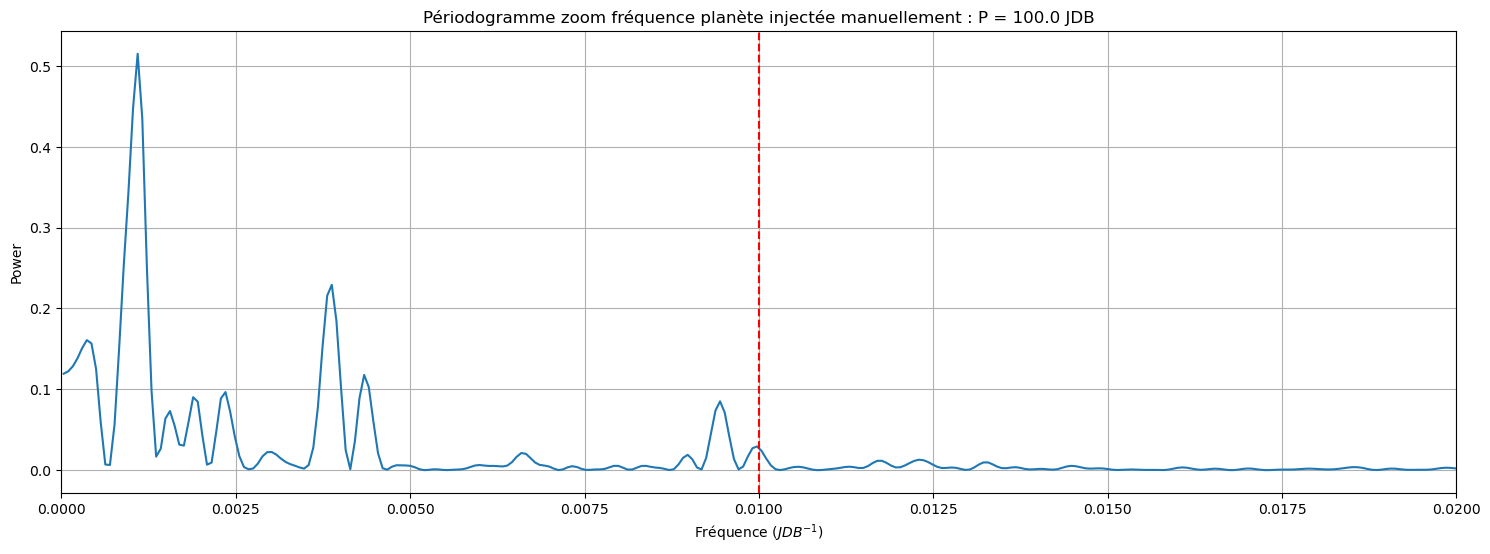

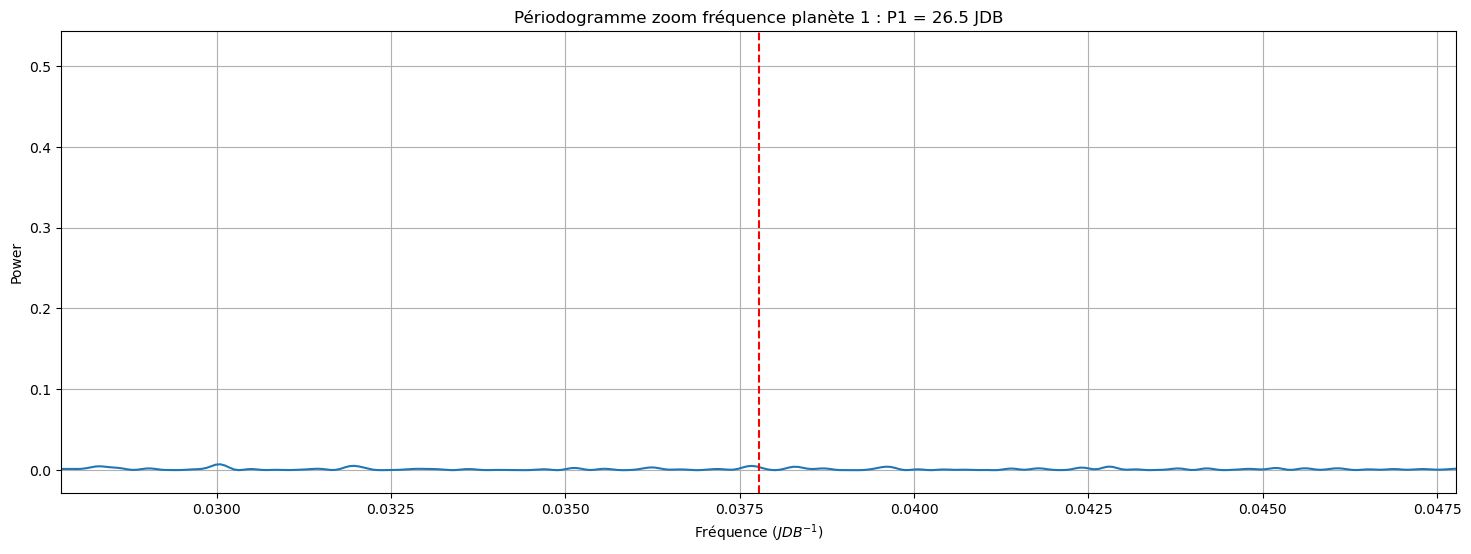

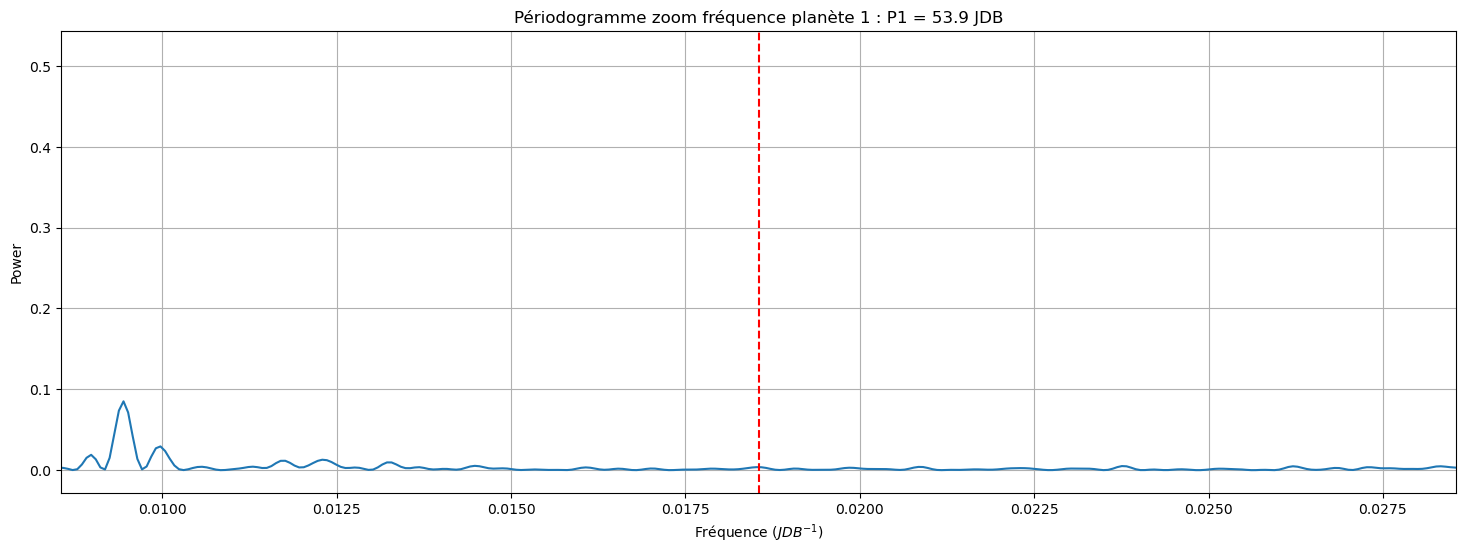

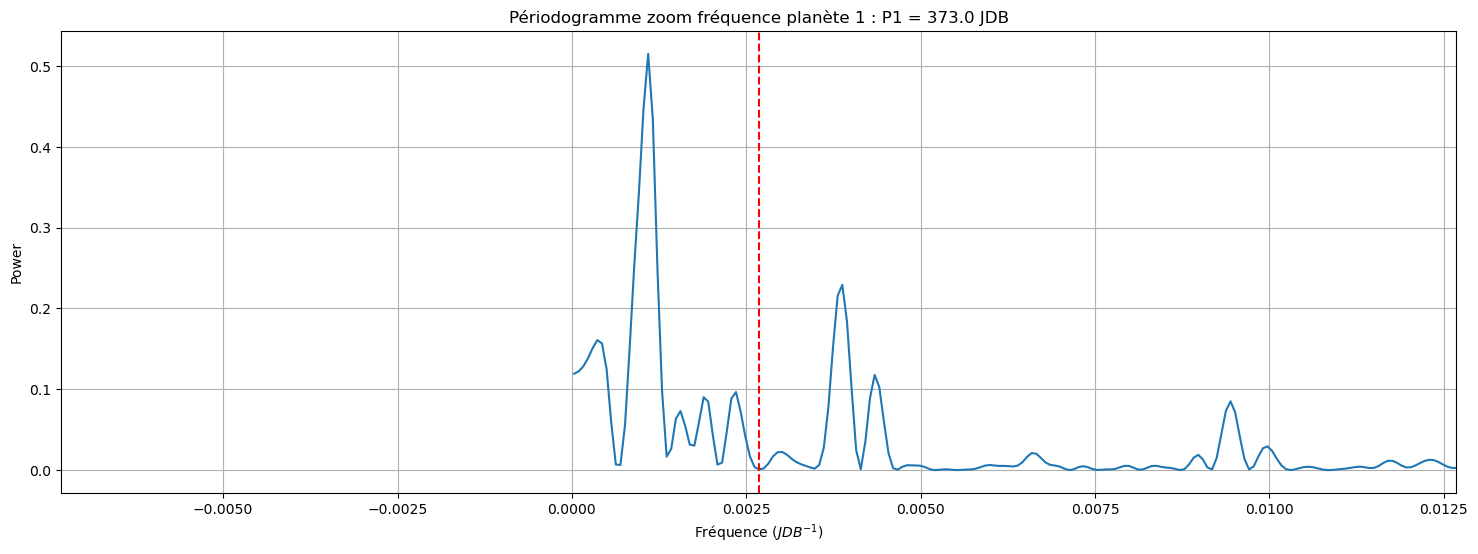

In [134]:
frequency, power = LombScargle(t, list_vencode).autopower()
%matplotlib inline
plt.figure(figsize=(18, 6))
plt.title(f'Périodogramme zoom fréquence planète injectée manuellement : P = {P:.1f} JDB')
plt.ylabel('Power')
plt.xlabel('Fréquence ($JDB^{-1}$)')
plt.plot(frequency, power)
plt.xlim(1/P-0.01, 1/P+0.01)
plt.axvline(x=1/P, color='r', linestyle='dashed')
plt.grid()
plt.show()    

for f in [f1, f2, f3]:
    plt.figure(figsize=(18, 6))
    plt.title(f'Périodogramme zoom fréquence planète 1 : P1 = {1/f:.1f} JDB')
    plt.ylabel('Power')
    plt.xlabel('Fréquence ($JDB^{-1}$)')
    plt.plot(frequency, power)
    plt.xlim(f-0.01, f+0.01)
    plt.axvline(x=f, color='r', linestyle='dashed')
    plt.grid()
    plt.show()